Let's implement KMeans in JAX, nothing crazy -- just getting to know JAX and see how we can get speed-ups

In [1]:
import jax.numpy as jnp
from jax import random, vmap, jit
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
KEY = random.PRNGKey(42)

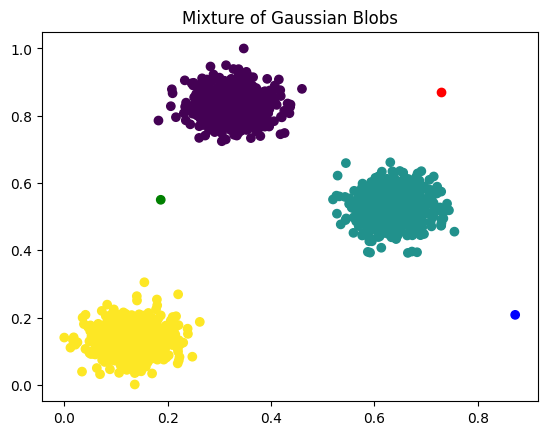

In [3]:
from sklearn.datasets import make_blobs

n_samples = 1500
X, y = make_blobs(n_samples=n_samples, random_state=42)

def standardize(x, mean, std):
    return (x - mean) / std

def normalize(x):
    return (x-jnp.min(x))/(jnp.max(x)-jnp.min(x))

X_mean = normalize(standardize(X, jnp.mean(X), jnp.std(X)))
y_mean = normalize(standardize(y, jnp.mean(y), jnp.std(y)))

# Model def
kmeans = {
    'prototypes': random.uniform(key=KEY, shape=(3, 2), minval=0, maxval=1)
}

plt.title("Mixture of Gaussian Blobs")
plt.scatter(X_mean[:, 0], X_mean[:, 1], c=y_mean)

plt.scatter(kmeans['prototypes'][:, 0], kmeans['prototypes'][:, 1], c=['r','b','g'])

Sklearn baseline

In [4]:
from sklearn.cluster import KMeans

In [5]:
%%capture sklearn_time
%%timeit
KMeans(n_clusters=3, n_init='auto', random_state=42, max_iter=50, verbose=False).fit_predict(X_mean)

Initialization complete
Iteration 0, inertia 8.847831726074219.
Iteration 1, inertia 5.644221782684326.
Converged at iteration 1: strict convergence.


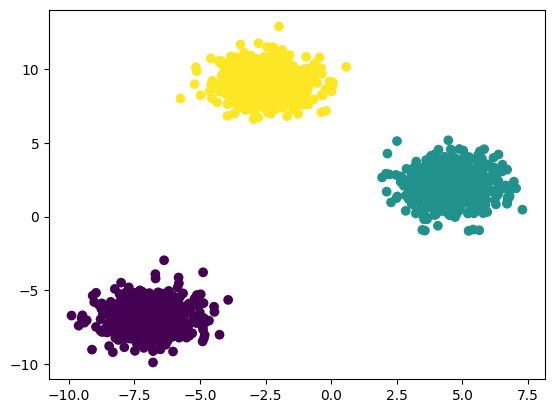

In [6]:
# Blobs are colored corresponding to cluster assignment
y_pred = KMeans(n_clusters=3, n_init='auto', random_state=42, max_iter=50, verbose=True).fit_predict(X_mean)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

Onto JAX...

In [7]:
@jit
def dist(x, y):
    return jnp.sqrt(jnp.sum(jnp.square(x - y), 1))

@jit
def binarize(a):
    return a <= jnp.min(a)

vdist = jit(vmap(dist, in_axes=(0, None), out_axes=0))
vbin  = jit(vmap(binarize, in_axes=0, out_axes=1))

d = vdist(X_mean, kmeans['prototypes'])
m = vbin(d)

In [8]:
%%timeit
vdist(X_mean, kmeans['prototypes'])

16.4 µs ± 233 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
%%timeit
# Transposing take 6x more time!
vdist(X_mean, kmeans['prototypes']).T

99.3 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
def step(params, x):
    d = vdist(x, params['prototypes'])
    min_ = jnp.argmin(d, 1)

    for i in range(len(params['prototypes'])):
        params['prototypes'] = params['prototypes'].at[i].set(jnp.mean(x[min_ == i], 0))

    return params

In [11]:
@jit
def vec_step(params, x):
    # TODO if we only have to use var once we don't have to declare it and can save time/saveMemoryError
    # Compute distance and create binary matrix 3 x N where [i, j] = True means point j is closest to prototype i
    bin_ = jnp.expand_dims(vbin(vdist(x, params['prototypes'])), -1)

    # Stack X n_class times, zero out using binary mat to get valid examples only then re-compute prototypes
    params['prototypes'] = jnp.divide(jnp.sum(jnp.stack([x] * 3, 0) * bin_, 1), bin_.sum(1))
    return params

# Run to let JIT trace
vec_step(kmeans, X_mean)['prototypes'];

From running Sklearn verbose we can see it converges in 2 iterations we'll set our steps to 5
_*TODO*_ implement early-stopping in future

In [12]:
%%capture jax_no_op_time
%%timeit
kmeans = {'prototypes': random.uniform(key=KEY, shape=(3, 2), minval=0, maxval=1)}
for _ in range(5):
    kmeans = step(kmeans, X_mean)

In [13]:
%%capture jax_op_time
%%timeit
kmeans = {'prototypes': random.uniform(key=KEY, shape=(3, 2), minval=0, maxval=1)}
for _ in range(5):
    kmeans = vec_step(kmeans, X_mean)

In [18]:
print(f"Sklearn:    \t{sklearn_time.stdout}"
      f"JAX (no-op):\t{jax_no_op_time.stdout}"
      f"JAX (op):   \t{jax_op_time.stdout}")

Sklearn:    	2.6 ms +- 36.4 us per loop (mean +- std. dev. of 7 runs, 100 loops each)
JAX (no-op):	34.2 ms +- 1.26 ms per loop (mean +- std. dev. of 7 runs, 1 loop each)
JAX (op):   	674 us +- 2.8 us per loop (mean +- std. dev. of 7 runs, 1,000 loops each)



Run again outside of timeit to actually see results

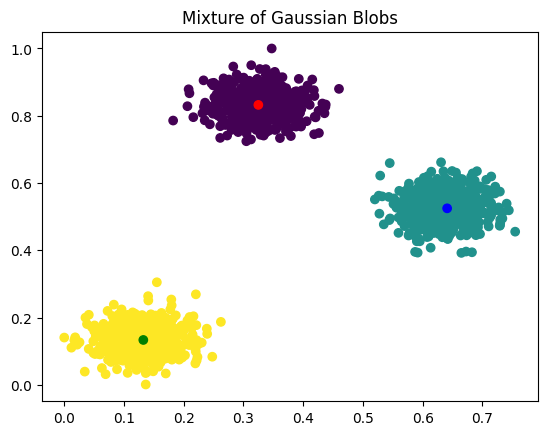

In [15]:
kmeans = {'prototypes': random.uniform(key=KEY, shape=(3, 2), minval=0, maxval=1)}

for _ in range(5):
    kmeans = vec_step(kmeans, X_mean)

plt.title("Mixture of Gaussian Blobs")
plt.scatter(X_mean[:, 0], X_mean[:, 1], c=y_mean)

# Here we just color the prototypes since we have access to them, given they're in the middle of each cluster you get the point (:
plt.scatter(kmeans['prototypes'][:, 0], kmeans['prototypes'][:, 1], c=['r','b','g'])